In [3]:
import numpy as np
import dolfinx
from dolfinx import mesh, fem, default_scalar_type
from mpi4py import MPI
import ufl
from dolfinx.fem.petsc import LinearProblem
import joblib
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ---------------------------
# Simulation Setup
# ---------------------------

# Beam dimensions and material properties
L, W, H = 0.06, 0.05, 0.03
rho, nu, E = 1, 0.48, 0.12e6
lambda_ = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (1 + 2 * nu)

# Mesh
domain = mesh.create_box(MPI.COMM_WORLD, [np.array([0, 0, 0]), np.array([L, W, H])],
                         [24, 9, 10], cell_type=mesh.CellType.hexahedron)

V = fem.functionspace(domain, ("Lagrange", 1, (3,)))  # vector displacement
V_von_mises = fem.functionspace(domain, ("DG", 0))    # scalar strain

# Dirichlet BC at z=0
def clamped_boundary(x): return np.isclose(x[2], 0)
fdim = domain.topology.dim - 1
boundary_facets = mesh.locate_entities_boundary(domain, fdim, clamped_boundary)
u_D = np.array([0, 0, 0], dtype=default_scalar_type)
bc = fem.dirichletbc(u_D, fem.locate_dofs_topological(V, fdim, boundary_facets), V)

ds = ufl.Measure("ds", domain=domain)

def epsilon(u): return ufl.sym(ufl.grad(u))
def sigma(u): return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2 * mu * epsilon(u)

# Sensor points fixed along x, y=0.025, z=0.0
sensor_points = [np.array([x, 0.025, 0.0]) for x in [0.01, 0.02, 0.03, 0.04, 0.05]]

# Force application points along x-axis
force_positions = np.arange(0.001, 0.070, 0.001)

# ---------------------------
# Data Collection
# ---------------------------

X_data = []
y_data = []
slice_coords = None

for fx in force_positions:
    # Trial and test functions
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    # Body force: localized downward pressure at (fx, 0.025, 0.03)
    x = ufl.SpatialCoordinate(domain)
    center = ufl.as_vector([fx, 0.025, 0.03])
    radius = 0.005
    chi = ufl.conditional(
        ufl.And(ufl.inner(x - center, x - center) < radius**2, (x[2] - center[2])**2 < 1e-5),
        1, 0)
    f = chi * fem.Constant(domain, default_scalar_type((0, 0, -1e6)))
    T = fem.Constant(domain, default_scalar_type((0, 0, 0)))

    a = ufl.inner(sigma(u), epsilon(v)) * ufl.dx
    L = ufl.dot(f, v) * ufl.dx + ufl.dot(T, v) * ds

    # Solve linear elasticity
    problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()

    # Compute strain ε_zz
    strain_zz = ufl.dot(ufl.dot(ufl.as_vector([0, 0, 1]), epsilon(uh)), ufl.as_vector([0, 0, 1]))
    strain_expr = fem.Expression(strain_zz, V_von_mises.element.interpolation_points())
    strain_func = fem.Function(V_von_mises)
    strain_func.interpolate(strain_expr)
    strain_func.name = "strain_zz"

    # Get DOF coordinates and strain values
    coords = V_von_mises.tabulate_dof_coordinates()
    vals = strain_func.x.array

    # Collect 2D slice at y ≈ 0.025
    slice_pts = []
    for i, pt in enumerate(coords):
        x_pt, y_pt, z_pt = pt
        if 0.023 <= y_pt <= 0.027:
            slice_pts.append((x_pt, z_pt, vals[i]))

    slice_pts = np.array(slice_pts)
    if slice_pts.shape[0] == 0:
        continue

    # Sort consistently
    slice_pts = slice_pts[np.lexsort((slice_pts[:,1], slice_pts[:,0]))]

    # Save coordinates once
    if slice_coords is None:
        slice_coords = slice_pts[:, :2]
    else:
        assert np.allclose(slice_coords, slice_pts[:, :2]), "Inconsistent slice coordinates across samples!"

    # Get sensor values (by nearest cell centroid)
    cell_centroids = np.zeros((domain.topology.index_map(domain.topology.dim).size_local, 3))
    for cell_id in range(len(cell_centroids)):
        cell_geometry = domain.geometry.x[domain.topology.connectivity(domain.topology.dim, 0).links(cell_id)]
        cell_centroids[cell_id] = np.mean(cell_geometry, axis=0)

    sensor_input = []
    for pt in sensor_points:
        distances = np.linalg.norm(cell_centroids - pt, axis=1)
        closest_cell = np.argmin(distances)
        sensor_val = strain_func.x.array[closest_cell]
        sensor_input.append(sensor_val)

    X_data.append(sensor_input)
    y_data.append(slice_pts[:, 2])  # ε_zz at all slice points

✅ Model with scaling + PCA trained and saved to 'strainzz_interpolator.pkl'
✅ Full Dataset MSE: 0.000000
✅ Full Dataset R² Score: 0.9896


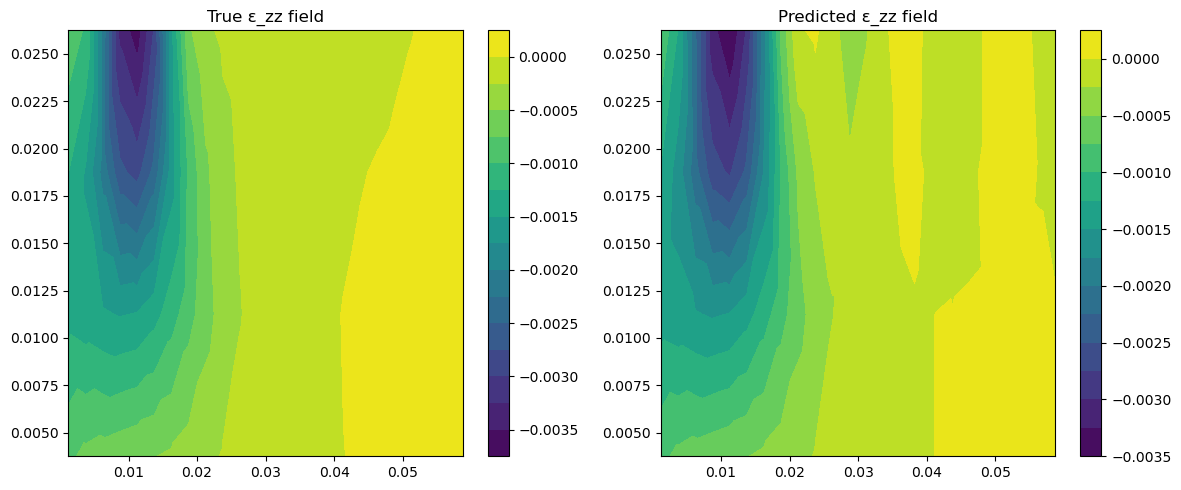

In [2]:
# ---------------------------
# Train Model
# ---------------------------

import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ---------------------------
# Preprocessing and Training
# ---------------------------

# Scale inputs and outputs
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X_data)
y_scaled = y_scaler.fit_transform(y_data)
X_noisy = X_scaled + np.random.normal(0, 0.01, X_scaled.shape)

# Reduce output dimensionality with PCA
pca = PCA(n_components=0.99)
y_pca = pca.fit_transform(y_scaled)

# Train model on PCA-compressed targets
regressor = MLPRegressor(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    alpha=1e-4,
    max_iter=10000,
    random_state=42
)
model = make_pipeline(StandardScaler(), regressor)  # second StandardScaler normalizes X_scaled
model.fit(X_noisy, y_pca)

# Save everything
joblib.dump({
    "model": model,
    "pca": pca,
    "X_scaler": X_scaler,
    "y_scaler": y_scaler,
    "slice_coords": slice_coords,
    "sensor_points": sensor_points
}, "strainzz_interpolator.pkl")

print("✅ Model with scaling + PCA trained and saved to 'strainzz_interpolator.pkl'")

# ---------------------------
# Evaluation
# ---------------------------

# Predict and reconstruct
y_pca_pred = model.predict(X_scaled)
y_scaled_pred = pca.inverse_transform(y_pca_pred)
y_pred = y_scaler.inverse_transform(y_scaled_pred)

# Metrics
mse = mean_squared_error(y_data, y_pred)
r2 = r2_score(y_data, y_pred)

print(f"✅ Full Dataset MSE: {mse:.6f}")
print(f"✅ Full Dataset R² Score: {r2:.4f}")

# ---------------------------
# Visualization
# ---------------------------

idx = 10  # Sample to visualize
true_field = y_data[idx]
pred_field = y_pred[idx]
x_coords, z_coords = slice_coords[:, 0], slice_coords[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.tricontourf(x_coords, z_coords, true_field, levels=14)
plt.title("True ε_zz field")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.tricontourf(x_coords, z_coords, pred_field, levels=14)
plt.title("Predicted ε_zz field")
plt.colorbar()

plt.tight_layout()
plt.show()
